# Simulating Lennard-Jones Potential and Forces on a Neon lattice

## Konstantinos Doran SN: 22007700

### Introduction:
This notebook, I will be first arranging a lattice of 64 Neon atoms. The atoms will be initialised with a temperature of 50K, using a normal distribution of the average kinetic energy of each particle: $3k_B T/2$. The Lennard-Jones Potential is given by:
$$V(r) = 4 \epsilon[(\frac{\sigma}{r})^{12} -(\frac{\sigma}{r})^6] $$
Where $\sigma$ and $\epsilon$ are The Lennard-Jones parameters, where $r=\sigma$ is where the potential crosses 0. The force from this potential is:
$$\vec{F_i(\vec{r_{ij}})} = 24 \epsilon\vec{r_{ij}}[\frac{\sigma^6}{r^8} -2\frac{\sigma^{12}}{r^{14}}] = -\vec{F_j(\vec{r_{ji}})}$$

In [1]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### 1. Set up the force/energy function

The following function was taken from Session 7 exercises to output the LJ forces and energy on each particle

In [2]:
def find_forces_LJ(pos,N,sigma,epsilon,boxlen):
    """
    Evaluate the force due to Lennard-Jones potential on an array of particles given their positions.
    
    Inputs:
    pos             Positions (Npart x 3 array)
    N               Number of particles
    sigma           LJ parameter
    epsilon         LJ parameter
    boxlen          Length of simulation cell
    
    Output:
    energy          LJ energy
    force           Forces on particles (Npart x 3 array)"""
    # Initialise force and energy
    force = np.zeros((N,3))
    energy = 0.0
    # Create new sigma variables for faster execution
    sigma6 = sigma**6
    sigma12 = sigma6*sigma6
    # Iterate over each particle and calculate force/energy exerted on each particle
    for i in range(N-1):
        for j in range(i+1,N):
            dr = pos[j]-pos[i]
            dr -= boxlen*np.rint(dr/boxlen)
            dr2 = np.sum(dr*dr)
            dr2i = 1.0/dr2
            dr6i = dr2i*dr2i*dr2i
            fij= 24.0*epsilon*dr*dr2i*dr6i*(sigma6 - 2.0*sigma12*dr6i)
            force[i] += fij
            force[j] -= fij
            energy += 4.0*epsilon*dr6i*(sigma12*dr6i - sigma6)
    return energy, force

### 2. Set up the lattice and the simulation parameters



In [3]:
# Initialisation
Nsteps = 10000
kB = 1.38e-23         # J/K
sigma = 0.275e-9      # 0.275nm
epsilon = 36*kB       # 36kT
mass = 20.2*1.673e-27 # kg
Ncells = 4
boxlen = 1.1 * 2**(1/6)*sigma
Npart = Ncells*Ncells*Ncells
rbox3 = np.zeros([Nsteps,Npart,3])
vbox3 = np.zeros([Nsteps,Npart,3])
count = 0
# Set positions of each particle
for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,count] = (1/Ncells)*boxlen*np.array([i,j,k])
            count += 1

Text(0.5, 0, 'z (m)')

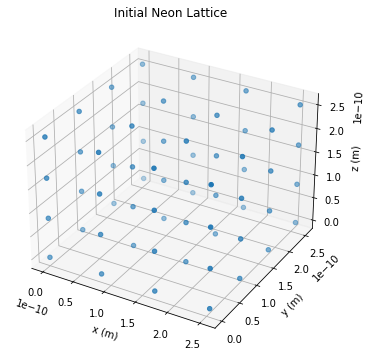

In [31]:
# Plot
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(rbox3[0,:,0],rbox3[0,:,1],rbox3[0,:,2])
# Set plot labels
ax1.set_title('Initial Neon Lattice')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('z (m)')

### 3. Initialise velocities

In [5]:
# Initialise velocities
initT  = 50          # K
# The initial distribution can have an arbitrary scaling
rng = np.random.default_rng()
vbox3[0] = rng.standard_normal(size=(Npart,3))
# These line rescales the velocities
v_scale = np.sqrt(3*Npart*kB*initT/(mass*np.sum(vbox3[0]*vbox3[0])))
vbox3[0] *= v_scale
energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)
e, f = find_forces_LJ(rbox3[0],Npart,sigma,epsilon,boxlen)
energy[0] = e
temp[0] = mass*np.sum(vbox3[0]*vbox3[0])/(3*Npart*kB)
acc = f/mass
dt = 1e-15 # s 
MSD = np.zeros(Nsteps-1)

### 4. Run simulation


In [6]:
for step in range(1,Nsteps):
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc
    # Periodic boundaries
    rbox3[step] = np.mod(rbox3[step],boxlen)
    energy[step], f = find_forces_LJ(rbox3[step],Npart,sigma,epsilon,boxlen)
    acc_next = f/mass
    vbox3[step] = vbox3[step-1] + 0.5*dt*(acc + acc_next)
    temp[step] = mass*np.sum(vbox3[step]*vbox3[step])/(3*Npart*kB)
    acc = acc_next
    # Calculate mean-squared displacement
    MSD[step-1] = np.sum((rbox3[step]-rbox3[0])*(rbox3[step]-rbox3[0]))
MSD /= Npart

Text(0.5, 1.0, 'Mean Square displacement against time')

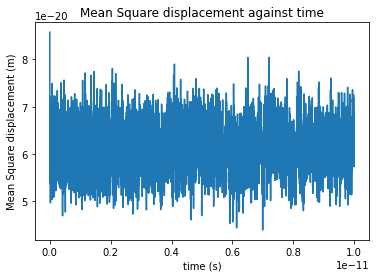

In [25]:
# Plot MSD
time = dt*np.arange(1,Nsteps)
plt.plot(time,MSD)
plt.ylabel('Mean Square displacement (m)')
plt.xlabel('time (s)')
plt.title("Mean Square displacement against time")

Text(0.5, 1.0, 'Convergence of displacement/time ')

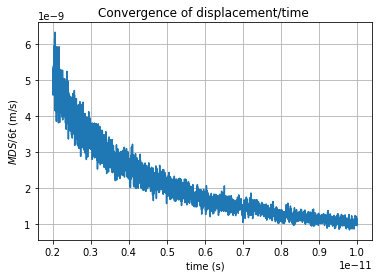

In [26]:
# Calculate MSD/time
MSD_t = MSD/(6*time) #m/s
#Plot
plt.plot(time[2000:], MSD_t[2000:])
plt.grid()
plt.ylabel(r'$MDS/6t$ (m/s)')
plt.xlabel('time (s)')
plt.title("Convergence of displacement/time ")

From the graph above it is evident that the Mean sqare displacement divided by time is tending towards $10^{-9}$ m/s.

### 5. Calculate the integral

Text(0.5, 1.0, 'Auto-correlation against time')

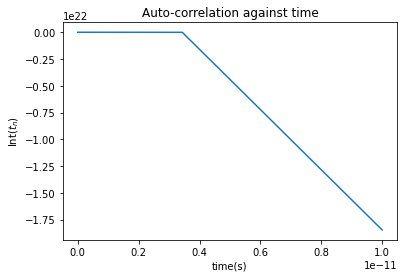

In [21]:
# Initialise
Int = np.zeros(Nsteps)
# At rectangle at each time step
for step in range(1,Nsteps):
    Int[step] = Int[step-1] + np.sum(vbox3[step]*vbox3[0])*dt
Int = Int/(3*Npart)
# Plot
plt.plot(time,Int[1:])
plt.ylabel(r'Int($t_n$)')
plt.xlabel('time (s)')
plt.title("Auto-correlation against time")

## Conclusion
I was having issues trying to implement the Integration as it wasn't clear whether it should be t or t_n in the equation in the notes and I dont want to spend too long on the assignment. Thus this is the result I got. This graph does not seem to converge. However from the converging graph we have a vcalue of $10^{-9}$ m/s. The converging value suggests that the particles will diffuse at $10^{-9}$ m/s when fewer external forces (i.e. LJ forces) have a significant effect on the velocity of the particles.